In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def sort_contours(cnts, method="left-to-right"):

    reverse = False
    i = 0

    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    
    return (cnts, boundingBoxes)

In [3]:
def order_points(pts):
    
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

In [4]:
def four_point_transform(image, pts):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

In [5]:
def display_img(img):
    fig = plt.figure(figsize=(14,10))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap='gray')

In [6]:
def display_col(img):
    fig = plt.figure(figsize=(14,10))
    ax3 = fig.add_subplot(111)
    img_col=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax3.imshow(img)

In [7]:
ANSWER_KEY = {0: 4, 1: 3, 2:2 , 3: 3, 4: 1}

In [41]:
img=cv2.imread('test_04.png')

In [42]:
orig=img.copy()

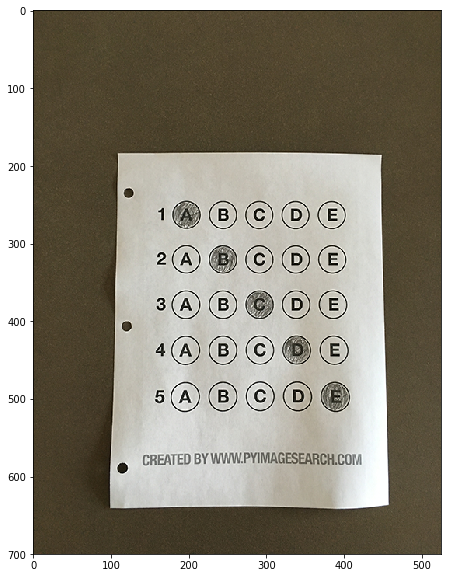

In [43]:
img_col=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(14,10))
plt.imshow(img_col)

In [44]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# USING HSV COLORING

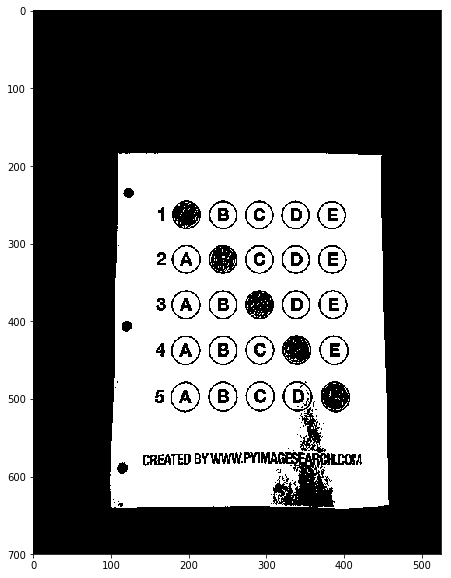

In [45]:
imgHsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV);

lower = np.array([0, 0, 180])
upper = np.array([255, 60, 255])

bw = cv2.inRange(imgHsv, lower, upper)

display_img(bw)

# USING THRESHOLD

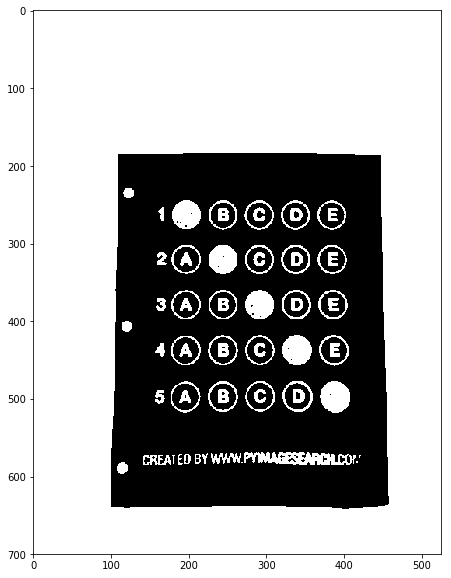

In [46]:
ret,thresh2 = cv2.threshold(gray.copy(),160,255,cv2.THRESH_BINARY_INV)
display_img(thresh2)


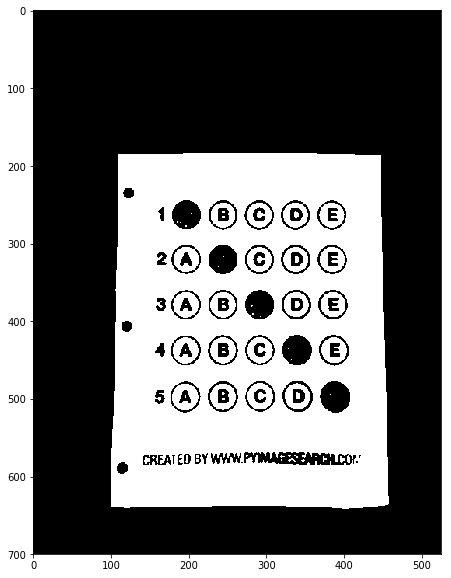

In [47]:
thresh21=cv2.bitwise_not(thresh2)
display_img(thresh21)

# USING EDGES

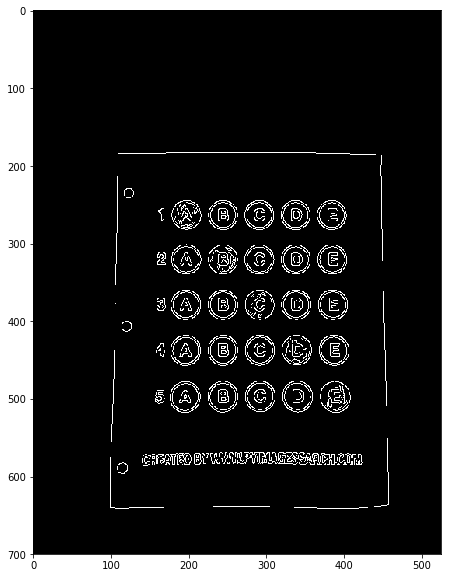

In [48]:
edged = cv2.Canny(gray, 75, 200)
display_img(edged)

In [49]:
contours,hierarchy = cv2.findContours(thresh21.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

In [50]:
len(contours)

135

In [51]:
# Drawing External Contours

# Set up empty array
external_contours = np.zeros(img.shape)


for i in range(len(contours)):
    
    # last column in the array is -1 if an external contour (no contours inside of it)
    if hierarchy[0][i][3] == -1:
        
        # We can now draw the external contours from the list of contours
        cv2.drawContours(external_contours, contours, i, (255), -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


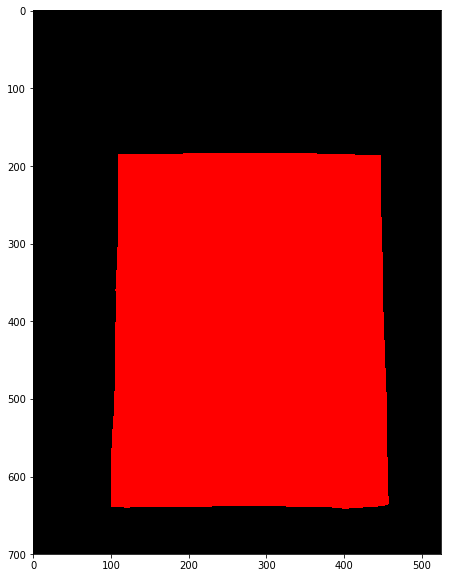

In [52]:
display_img(external_contours)

In [53]:
cnts = sorted(contours, key = cv2.contourArea, reverse = True)

In [54]:
for c in cnts:
# approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # if our approximated contour has four points, then we
    # can assume that we have found our screen
    if len(approx) == 4:
        screenCnt = approx
        break

In [55]:
approx

array([[[110, 185]],

       [[100, 639]],

       [[456, 636]],

       [[447, 187]]], dtype=int32)

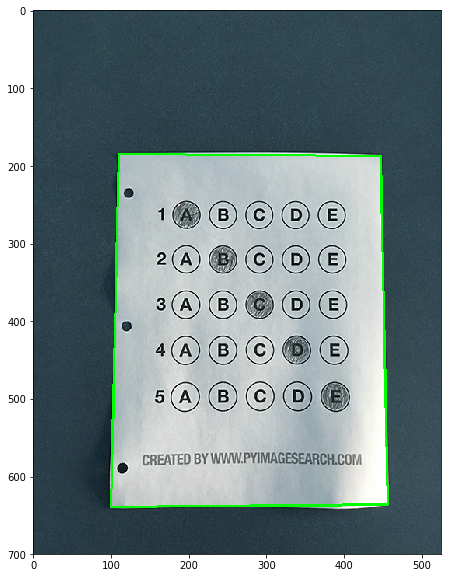

In [56]:
cv2.drawContours(img, [screenCnt], -1, (0, 255, 0), 2)
display_img(img)

In [57]:
paper = four_point_transform(orig, screenCnt.reshape(4,2) )
warped = four_point_transform(gray.copy(), screenCnt.reshape(4,2))

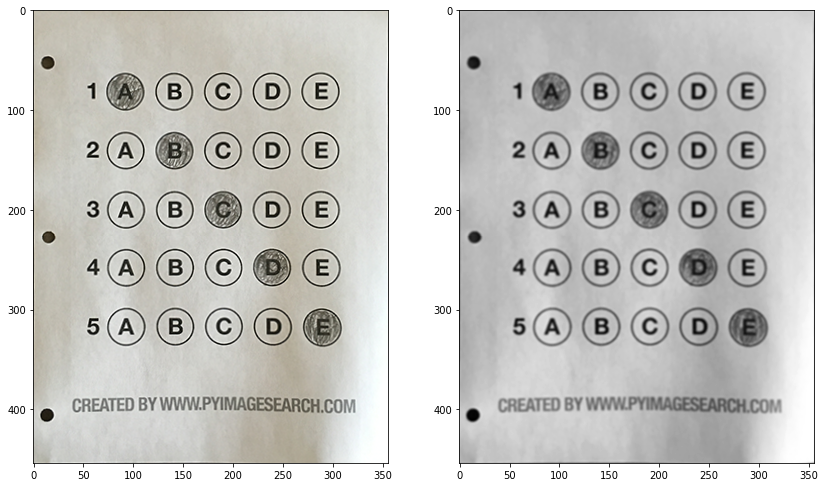

In [58]:
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
paper_col=cv2.cvtColor(paper,cv2.COLOR_BGR2RGB)
ax1.imshow(paper_col)
ax2.imshow(warped,cmap='gray')

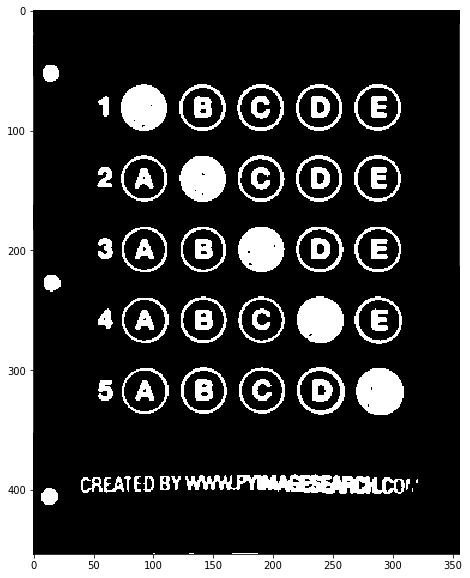

In [59]:
ret,thresh = cv2.threshold(warped,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

display_img(thresh)


# CONTOURS OF THRESHOLDED IMAGE

In [60]:
contours1,hierarchy1 = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [61]:
quesCnts=[]

In [62]:
for c in contours1:
    (x,y,w,h)=cv2.boundingRect(c)
    ar=w/float(h)
    
    if w>=20 and h>=20 and ar>=0.9 and ar<=1.1:
        quesCnts.append(c)

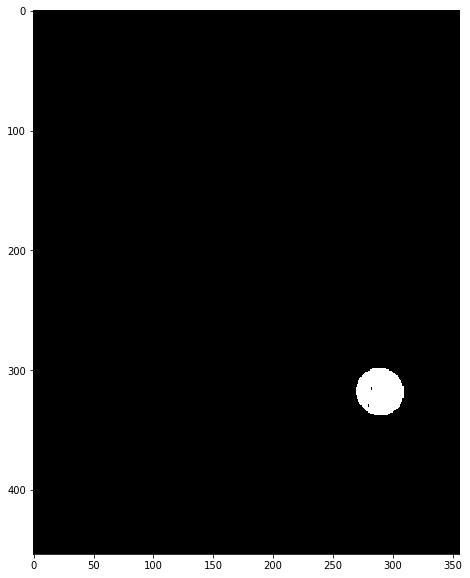

In [63]:
mask1=np.zeros(thresh.shape,dtype="uint8")
cv2.drawContours(mask1,[quesCnts[0]],-1,255,-1)
mask1 = cv2.bitwise_and(thresh, thresh, mask=mask1)
display_img(mask1)

In [64]:
# Drawing External Contours

# Set up empty array
external_contours = np.zeros(thresh.shape)


for i in range(len(quesCnts)):
    
    # last column in the array is -1 if an external contour (no contours inside of it)
    if hierarchy[0][i][3] == -1:
        
        # We can now draw the external contours from the list of contours
        cv2.drawContours(external_contours, quesCnts, i, (255), 2)

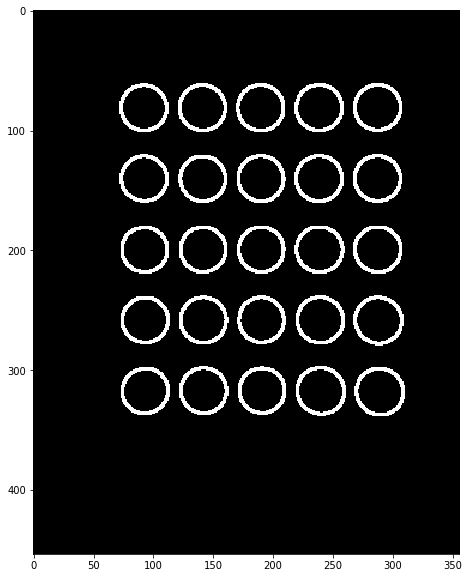

In [65]:
display_img(external_contours)

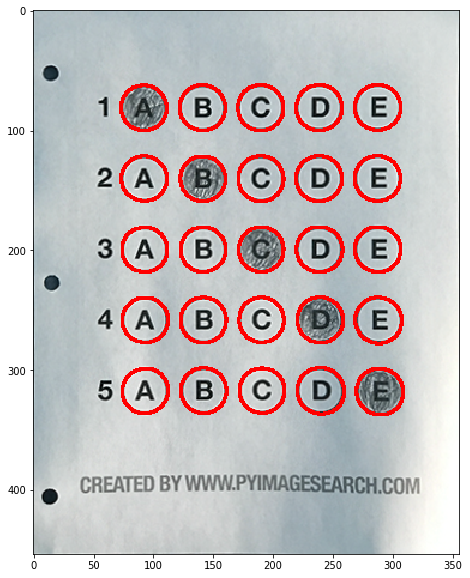

In [66]:
img2=paper.copy()
cv2.drawContours(img2, quesCnts, -1, (255,0,0), 2)
display_img(img2)

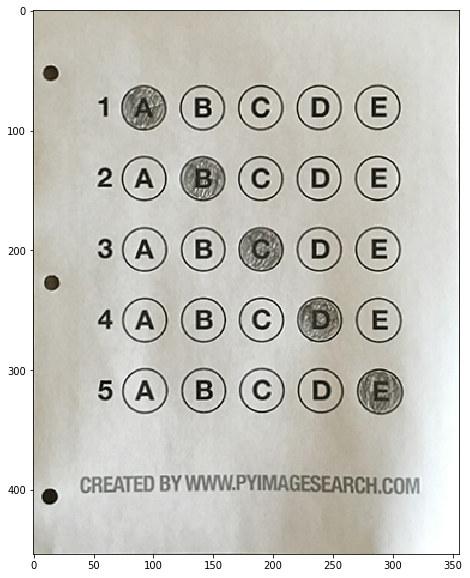

In [67]:
display_col(paper_col)

In [68]:
len(quesCnts)

25

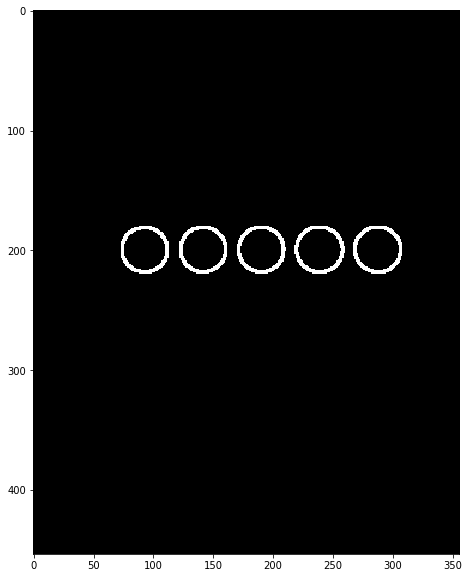

In [69]:
(quesCnts1,_)=sort_contours(quesCnts,method="top-to-bottom")
# Drawing External Contours
(row1,_)=sort_contours(quesCnts1[10:15],method="left-to right")
# Set up empty array
external_contours = np.zeros(warped.shape)



cv2.drawContours(external_contours, row1 ,-1, (255), 2)

display_img(external_contours)

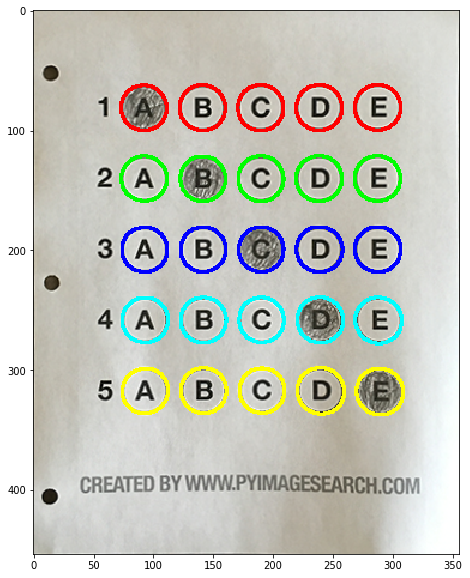

In [70]:
quesCnts,_=sort_contours(quesCnts,method="top-to-bottom")

img3=paper_col.copy()

for (q,i) in enumerate(np.arange(0,len(quesCnts),5)):
    cnts,_ = sort_contours(quesCnts[i:i + 5])
    
    if q==0:
        cv2.drawContours(img3,cnts,-1,(255,0,0),2)
    elif q==1:
        cv2.drawContours(img3,cnts,-1,(0,255,0),2)
    elif q==2:
        cv2.drawContours(img3,cnts,-1,(0,0,255),2)
    elif q==3:
        cv2.drawContours(img3,cnts,-1,(0,255,255),2)
    elif q==4:
        cv2.drawContours(img3,cnts,-1,(255,255,0),2)

display_col(img3)

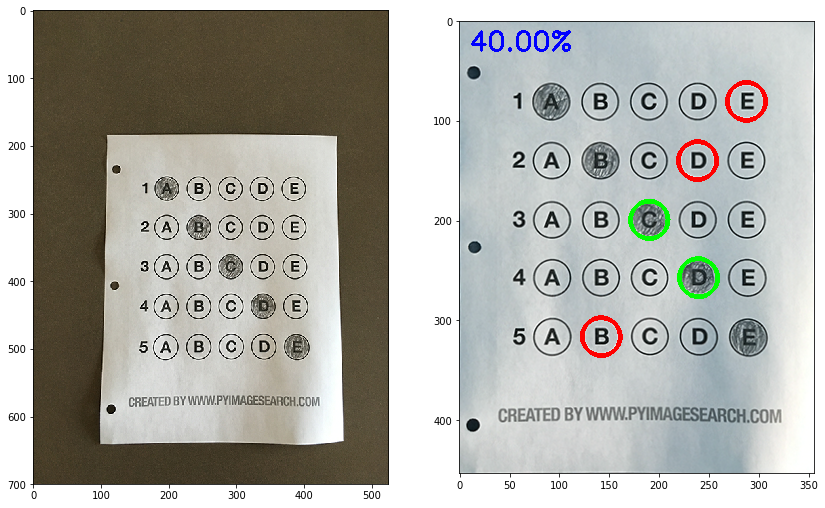

In [71]:
correct=0

for (q,i) in enumerate(np.arange(0,len(quesCnts),5)):
    cnts,_ = sort_contours(quesCnts[i:i + 5])
    bubbled=None
    
    for (j,c) in enumerate(cnts):
        mask=np.zeros(thresh.shape,dtype='uint8')
        cv2.drawContours(mask,[c],-1,255,-1)
        
        mask=cv2.bitwise_and(thresh,thresh,mask=mask)
        
        total=cv2.countNonZero(mask)
        
        if bubbled is None or total>bubbled[0]:
            if total>500:
                bubbled=(total,j)
            else:
                bubbled=None
    
    color=(255,0,0)
    k=ANSWER_KEY[q]
    
    
    
    if bubbled==None:
        color=(255,255,0)
    elif k==bubbled[1]:
        color=(0,255,0)
        correct=correct+1
        
    cv2.drawContours(paper,[cnts[k]],-1,color,3)

    
score=(correct/5.0)*100
cv2.putText(paper, "{:.2f}%".format(score), (10, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)


fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
paper_col=cv2.cvtColor(paper,cv2.COLOR_BGR2RGB)
orignal=cv2.cvtColor(orig,cv2.COLOR_BGR2RGB)
ax1.imshow(orignal)
ax2.imshow(paper)